# Prep

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import subprocess
import pandas as pd
from MP import read_blocks
from glob import glob
from TX import upf, cod_section
from matplotlib.gridspec import GridSpec
import os
from TX import euler

def gen_fig(nrows=3,ncols=3,colsize=2.5,rowsize=2.,**kwargs):
    gs=GridSpec(nrows=nrows,ncols=ncols,**kwargs)
    fig=plt.figure(figsize=(colsize*ncols,rowsize*nrows))
    axes=np.empty((nrows,ncols),dtype='object')
    for i in range(nrows):
        for j in range(ncols):
            ax=fig.add_subplot(gs[i,j])
            axes[i,j]=ax
    return fig,axes

def cart2voigt(sig):
    s6=np.zeros(6)
    for iv in range(6):
        i,j=ijvs[iv]
        s6[iv]=sig[i,j]
    return s6
def transf(R,A):
    """
    B[i,j]= R[i,k] R[j,l] A[k,l]
    """
    B=np.zeros((3,3))
    for i in range(3):
        for j in range(3):       
            for k in range(3):
                for l in range(3):
                    B[i,j]=B[i,j]+R[i,k]*R[j,l]*A[k,l]
    return B    

# Build _schmid_factor_ executable

In [2]:
loc_obj='/Users/youngung/repo/evpsc/objdir/'

In [3]:
!cd {loc_obj}/.. && pwd && make -j evpsc &&cd -

#!cp -v ../../evpsc/src/vpsc_src/library7.sub lib7.f
!gfortran -c lib7.f -o lib7.o
!gfortran -c schmid_factor.f -o schmid_factor.o

objfiles=['crystal_symmetry.o','chg_basis.o','voigt.o','fake_xit.o',
          'data_crystal_fe.o','funcs.o','lu_libs.o','thermo_emod_cte.o','lib_write.o']
cmd='gfortran schmid_factor.o'
for i, obj in enumerate(objfiles):
    cmd=f'{cmd} {os.path.join(loc_obj,obj)}'

cmd=f'{cmd} lib7.o -o schmid_factor'
print(f'cmd: {cmd}')
p=subprocess.Popen(cmd.split(),stdout=subprocess.PIPE,stderr=subprocess.PIPE)
stdo,stde=p.communicate()
print(stdo.decode()); print(stde.decode())

/Users/youngung/repo/evpsc
gfortran -I./src/vpsc_src/ -finit-local-zero  -finit-integer=zero -finit-logical=true -fno-automatic -fno-align-commons -fbackslash -fbounds-check -finit-real=zero -fdefault-double-8 -fdefault-real-8  -g -fbacktrace -ffast-math -Wuninitialized  -O3  -c src/vpsc_src/evpsc_main.f -o objdir/evpsc_main.o
gfortran -I./src/vpsc_src/ -finit-local-zero  -finit-integer=zero -finit-logical=true -fno-automatic -fno-align-commons -fbackslash -fbounds-check -finit-real=zero -fdefault-double-8 -fdefault-real-8  -g -fbacktrace -ffast-math -Wuninitialized  -O3  -c src/vpsc_src/evpsc_input_fe.f -o objdir/evpsc_input_fe.o
gfortran -I./src/vpsc_src/ -finit-local-zero  -finit-integer=zero -finit-logical=true -fno-automatic -fno-align-commons -fbackslash -fbounds-check -finit-real=zero -fdefault-double-8 -fdefault-real-8  -g -fbacktrace -ffast-math -Wuninitialized  -O3  -c src/vpsc_src/elsc_evp_fe.f -o objdir/elsc_evp_fe.o
gfortran -I./src/vpsc_src/ -finit-local-zero  -finit-inte

# Example stand-alone run of _schmid_factor_

In [4]:
%%time
## executable     single crystal file name                                            #S11, S22, S33, S23, S13, S12
!./schmid_factor /Users/youngung/repo/evpsc/matData/vpscData/CP-Ti-ICN/dd_298.sx        1.   0.5   0.   0.   0.   0. | cat -n 
#!./schmid_factor /Users/youngung/repo/evpsc/matData/vpscData/STS304/STS304.sx           1.   0.5   0.   0.   0.   0.

#!./schmid_factor /Users/youngung/repo/evpsc/examples/ex14_rex/NiFe.sx 1 0.5 0. 0. 0. 0.

     1	         Stress tensor in crystal axes                 
     2	    1.000    0.000    0.000
     3	    0.000    0.500    0.000
     4	    0.000    0.000    0.000
     5	         sel 66                 
     6	  0.8830E-05 -0.1836E-21  0.0000E+00  0.0000E+00  0.0000E+00 -0.6079E-07
     7	 -0.1462E-21  0.1420E-04  0.0000E+00  0.0000E+00  0.0000E+00  0.7219E-22
     8	  0.0000E+00  0.0000E+00  0.1071E-04  0.0000E+00  0.0000E+00  0.0000E+00
     9	  0.0000E+00  0.0000E+00  0.0000E+00  0.1071E-04  0.0000E+00  0.0000E+00
    10	  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.3931E-05  0.0000E+00
    11	 -0.6079E-07 -0.1004E-22  0.0000E+00  0.0000E+00  0.0000E+00  0.3108E-05
    12	Elastic energy:   0.7353E-05
    13	 ** imod:           1
    14	 dnca:   0.00  0.00  1.00  dbca:   1.00  0.00  0.00  schf:   0.0000  emod:   0.18E+06
    15	 dnca:   0.00  0.00  1.00  dbca:  -0.50  0.87  0.00  schf:   0.0000  emod:   0.18E+06
    16	 dnca:   0.00  0.00  1.00  dbca:  -0.50 -0.87  0.00  s

# Wrapper

In [5]:
def calc_sch(fnsx,stress,imod):
    cmd=f'./schmid_factor {fnsx}'
    for i, val in enumerate(stress):
        cmd=f'{cmd} {val}'
    p=subprocess.Popen(cmd.split(),stdout=subprocess.PIPE,stderr=subprocess.PIPE)
    stdout,stderr=p.communicate() 
    rst_lines=stdout.decode().split('\n')

    ## -----------------------------------------
    ## elastic energy
    energy_el=float(rst_lines[11].split()[-1])

    ## -----------------------------------------
    ## extract schmid factor calculation results
    for i, line in enumerate(rst_lines):
        if line[:3]==' **': 
            i0=i
            break
    rst=rst_lines[i0:]
    ind0=[];ind1=[]
    for i, line in enumerate(rst):
        if line[:3]==' **':
            ind0.append(i+1)
        if line=='':
            ind1.append(i)
    #print('ind0, ind1')
    #print(ind0)
    #print(ind1)
    rst_mode=rst[ind0[imod]:ind1[imod]]
    schfs=np.zeros(len(rst_mode))
    emods=np.zeros(len(rst_mode))
    for isys, line in enumerate(rst_mode):
        schfs[isys]=float(line.split('schf:')[-1].split()[0])
        emods[isys]=float(line.split('emod:')[-1].split()[0])
    ## -----------------------------------------


    
    #return max(schfs)
    return max(abs(schfs)), energy_el

In [6]:
#%%time
fnsx='/Users/youngung/repo/evpsc/matData/vpscData/CP-Ti-ICN/dd_298.sx'
#fnsx='/Users/youngung/repo/evpsc/matData/vpscData/STS304/STS304.sx'
#fnsx='/Users/youngung/repo/evpsc/matData/vpscData/DP_RGVB/F_voce.sx'
#fnsx='/Users/youngung/repo/evpsc/matData/vpscData/STS304/STS304.sx'
#fnsx='/Users/youngung/repo/evpsc/examples/ex14_rex/NiFe.sx'
stress=[0.,-0.5,-1,  0.,0.,0.]
ijvs=[[0,0],[1,1],[2,2],[1,2],[0,2],[0,1]]
## stress tensor in cartesian basis
sig=np.zeros((3,3))
for iv in range(6):
    i,j=ijvs[iv]
    sig[i,j]=stress[iv]
    sig[j,i]=sig[i,j]
#rst=calc_sch(fnsx=fnsx,stress=stress,imod=0)

In [7]:
nx,ny=20,20
phi1=np.linspace(0,90,nx)# * np.pi/180.
Phi =np.linspace(0,90,ny)# * np.pi/180.
phi1,Phi=np.meshgrid(phi1,Phi)

In [8]:
%%time
nmodes=3
phi2s=[0,45.,65]
schmid=np.zeros((len(phi2s),nmodes,*phi1.shape))
enerel=np.zeros((len(phi2s),*phi1.shape))

for i, phi2 in enumerate(phi2s):
    for ix in range(nx):
        for iy in range(ny):
            for imod in range(nmodes): 
                A=euler.euler(ph=phi1[ix,iy],th=Phi[ix,iy],tm=phi2,echo=False)
                newsig=transf(A,sig)
                newsig=cart2voigt(newsig)
                schmid[i,imod,ix,iy],energy=calc_sch(fnsx=fnsx,stress=newsig,imod=imod)
            ##
            enerel[i,ix,iy]=energy/1e3

CPU times: user 627 ms, sys: 3.01 s, total: 3.64 s
Wall time: 9.81 s


# Schmid factor maps

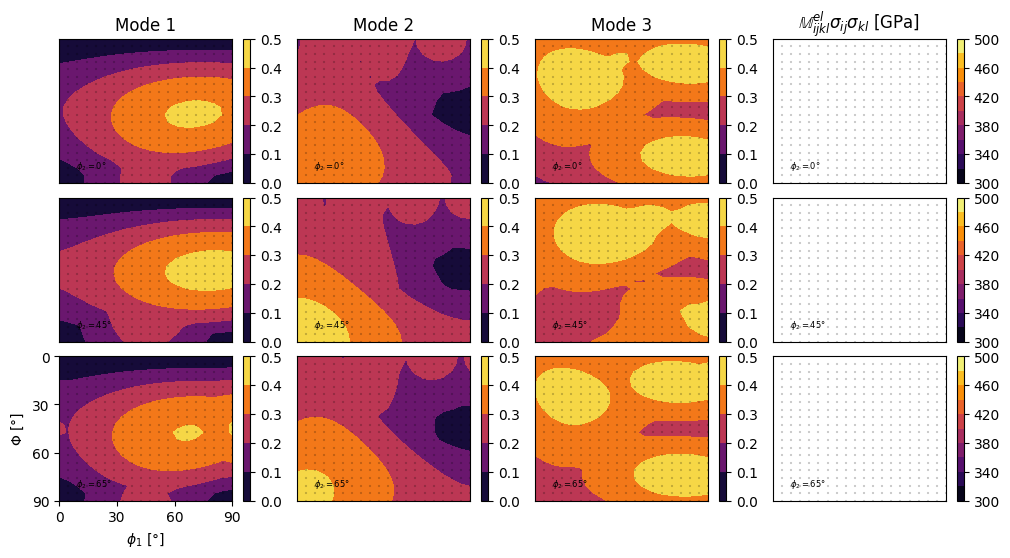

In [9]:
fig,axes=gen_fig(nrows=len(phi2s),ncols=nmodes+1,wspace=0.1,hspace=0.1,colsize=3)

kwargs=dict(cmap='inferno',levels=np.linspace(0.,0.5,6))
kwargs_el=kwargs.copy()
kwargs_el.update(levels=np.linspace(300,500,11))
cnts=np.empty((len(phi2s),nmodes+1),dtype='object')
for i, phi2 in enumerate(phi2s):
    for imod in range(nmodes):
        cnt=axes[i,imod].contourf(phi1,Phi,schmid[i,imod],**kwargs)
        cnts[i,imod]=cnt
        #plt.colorbar(cnt)
    cnt=axes[i,-1].contourf(phi1,Phi,enerel[i],**kwargs_el)
    cnts[i,imod+1]=cnt
    #plt.colorbar(cnt)

## decoration
for i, phi2 in enumerate(phi2s):
    for imod in range(nmodes+1):
        if i==0:
            if imod<nmodes : axes[i,imod].set_title(f'Mode {imod+1}')
            if imod==nmodes: axes[i,imod].set_title(r'$\mathbb{M}^{el}_{ijkl}\sigma_{ij}\sigma_{kl}$ [GPa]')
    
        axes[i,imod].set_ylim(90,0)
        axes[i,imod].set_xticks(np.linspace(0,90,4))
        axes[i,imod].set_yticks(np.linspace(0,90,4))
        axes[i,imod].set_xlabel(r'$\phi_1\ [\degree]$')
        axes[i,imod].set_ylabel(r'$\Phi\ [\degree]$')
        axes[i,imod].scatter(phi1,Phi,marker='+',s=1,c='k',alpha=0.2)

        axes[i,imod].text(0.1,0.1,s=r'$\phi_2= %3.0f\degree$'%phi2,ha='left',transform=axes[i,imod].transAxes,c='k',fontsize=6)


        if not(i==len(phi2s)-1 and imod==0): 
            axes[i,imod].axes.get_xaxis().set_visible(False)
            axes[i,imod].axes.get_yaxis().set_visible(False)

        plt.colorbar(cnts[i,imod])